In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(arrow))
suppressPackageStartupMessages(library(RColorBrewer))

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”
Warning message:
“package ‘arrow’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”


In [2]:
figure_dir <- "../figures"
output_main_figure_2 <- file.path(
    figure_dir, "main_figure_2_UMAP_sc_correlations.png"
)

## UMAP

In [3]:
# Path to UMAP results
UMAP_results_dir <- file.path(
    "../../../nf1_cellpainting_data/4.analyze_data/notebooks/UMAP/results/"
)

# Load data
UMAP_results_file <- file.path(UMAP_results_dir, "UMAP_concat_model_plates_sc_feature_selected.tsv")

UMAP_results_df <- readr::read_tsv(UMAP_results_file)

dim(UMAP_results_df)
head(UMAP_results_df)

Rows: 24237 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Metadata_Plate, Metadata_Well, Metadata_genotype
dbl (4): Metadata_Site, Metadata_number_of_singlecells, UMAP0, UMAP1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 24237     7

Metadata_Site,Metadata_number_of_singlecells,Metadata_Plate,Metadata_Well,Metadata_genotype,UMAP0,UMAP1
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
4,647,Plate_3,F12,Null,2.687171,5.165305
13,91,Plate_3_prime,F2,WT,2.533981,2.970483
10,148,Plate_5,B11,Null,3.926548,1.769879
4,187,Plate_3_prime,G12,Null,4.177299,2.142064
12,321,Plate_3_prime,C12,Null,2.913246,3.650136
22,281,Plate_3,C11,Null,1.897312,3.697691


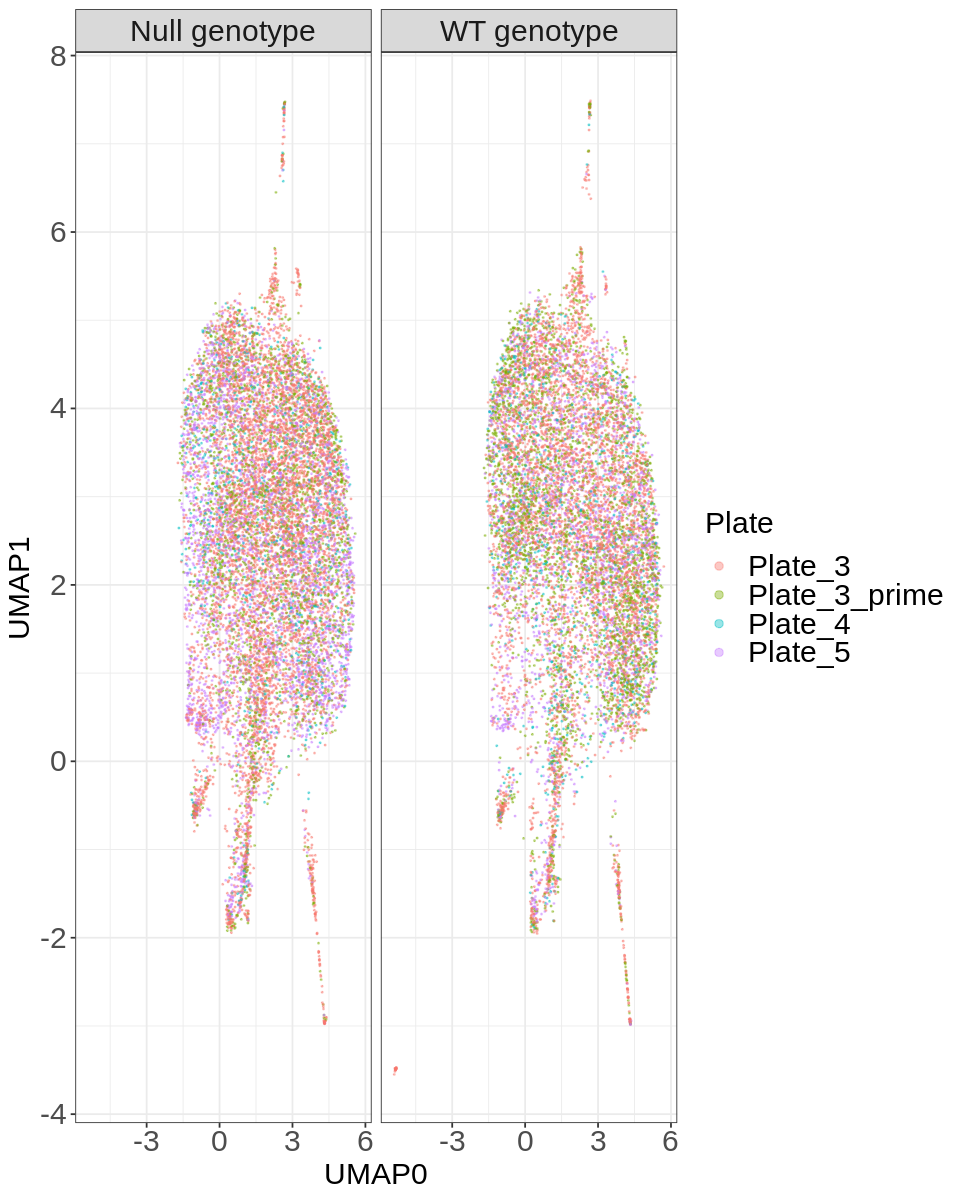

In [4]:
# Create a function to add "nM" to the end of each facet dose label
custom_labeller <- function(variable) {
  paste0(variable, " genotype")
}

width <- 8
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

umap_fig_gg <- (
  ggplot(UMAP_results_df, aes(x = UMAP0, y = UMAP1))
  + geom_point(
      aes(color = Metadata_Plate),
      size = 0.2,
      alpha = 0.4
  )
  + facet_grid(~ Metadata_genotype, labeller = labeller(Metadata_genotype = custom_labeller))
  + theme_bw()
  + guides(
      color = guide_legend(
          override.aes = list(size = 2)
      )
  )
  + labs(x = "UMAP0", y = "UMAP1", color = "Plate")
  # change the text size
  + theme(
      strip.text = element_text(size = 18),
      # x and y axis text size
      axis.text.x = element_text(size = 18),
      axis.text.y = element_text(size = 18),
      # x and y axis title size
      axis.title.x = element_text(size = 18),
      axis.title.y = element_text(size = 18),
      # legend text size
      legend.text = element_text(size = 18),
      legend.title = element_text(size = 18)
  )
)

umap_fig_gg

## Pairwise correlations (per well per plate for each genotype)

In [5]:
# Path to correlation per plate results
corr_results_dir <- file.path(
    "../../0.data_analysis/construct_phenotypic_expression_plate_4_fs_data/median_correlation_relationships/post_fs_aggregation_correlations/construct_correlation_data"
)

# Load data
corr_results_file <- file.path(corr_results_dir, "concatenated_all_plates_correlations.parquet")

corr_results_df <- arrow::read_parquet(corr_results_file)

corr_results_df$same_genotype <- corr_results_df$Metadata_genotype__group0 == corr_results_df$Metadata_genotype__group1

dim(corr_results_df)
head(corr_results_df)

[1] 3489   10

correlation,Metadata_Well__group0,Metadata_Well__group1,Metadata_genotype__group0,Metadata_genotype__group1,Metadata_plate__group0,Metadata_plate__group1,Metadata_seed_density__group0,Metadata_seed_density__group1,same_genotype
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<lgl>
0.258957011,B2,B5,WT,WT,Plate_4,Plate_4,1000,1000,TRUE
0.549560750,B2,B8,WT,WT,Plate_4,Plate_4,1000,1000,TRUE
0.251701422,B2,B11,WT,WT,Plate_4,Plate_4,1000,1000,TRUE
0.007696695,B2,C2,WT,Null,Plate_4,Plate_4,1000,1000,FALSE
-0.280606706,B2,C5,WT,Null,Plate_4,Plate_4,1000,1000,FALSE
-0.124466644,B2,C8,WT,Null,Plate_4,Plate_4,1000,1000,FALSE


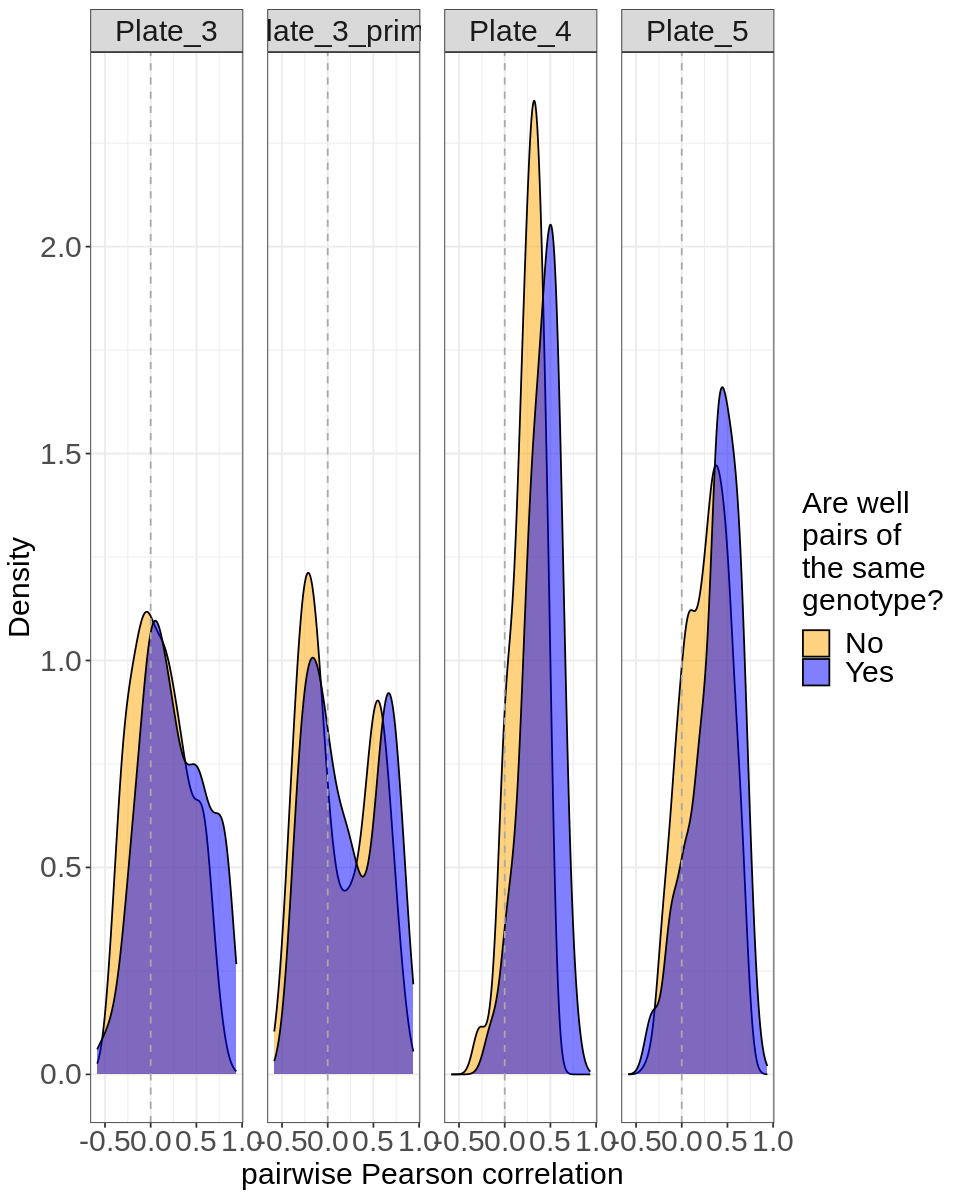

In [6]:
focus_corr_colors = c(
    "TRUE" = "blue",
    "FALSE" = "orange"
)
focus_corr_labels  = c(
    "TRUE" = "Yes",
    "FALSE" = "No"
)

genotype_corr_gg <- (
    ggplot(corr_results_df, aes(x = correlation))
    + geom_density(aes(fill = same_genotype), alpha = 0.5)
    + facet_grid("~Metadata_plate__group0")
    + scale_fill_manual(
        "Are well\npairs of\nthe same\ngenotype?",
        values = focus_corr_colors,
        labels = focus_corr_labels
    )
    + guides(
        color = guide_legend(
            override.aes = list(size = 2)
        )
    )
    + labs(x = "pairwise Pearson correlation", y = "Density")
    + geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey")
    + theme_bw()
    # change the text size
    + theme(
        strip.text = element_text(size = 18),
        # x and y axis text size
        axis.text.x = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        # x and y axis title size
        axis.title.x = element_text(size = 18),
        axis.title.y = element_text(size = 18),
        # legend text size
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 18),
        # Adjust the spacing between facet panels horizontally
        panel.spacing.x = unit(1, "lines")
    )
)

genotype_corr_gg

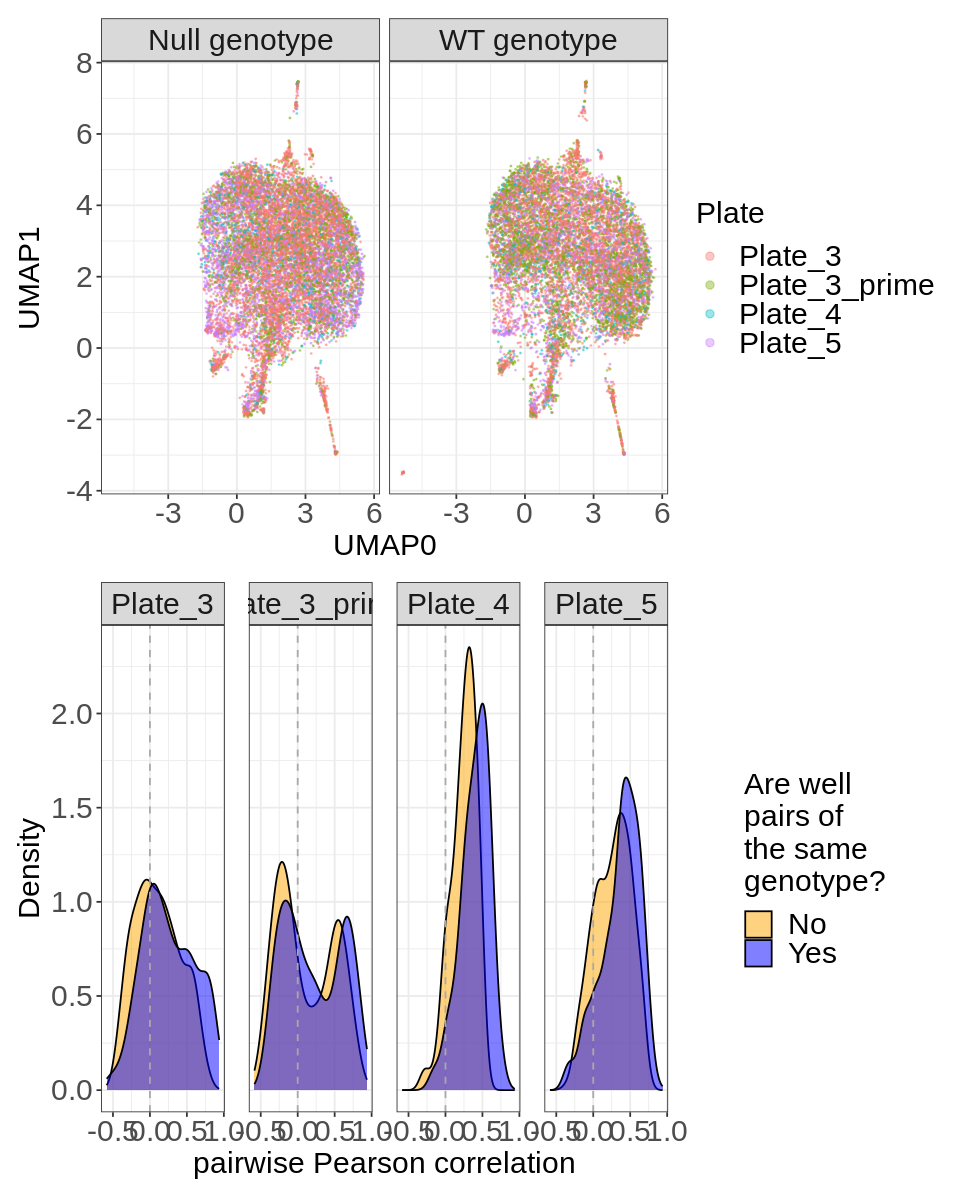

In [7]:
align_plot <- (
    umap_fig_gg /
    genotype_corr_gg
) + plot_layout(heights = c(2,2.25))

align_plot

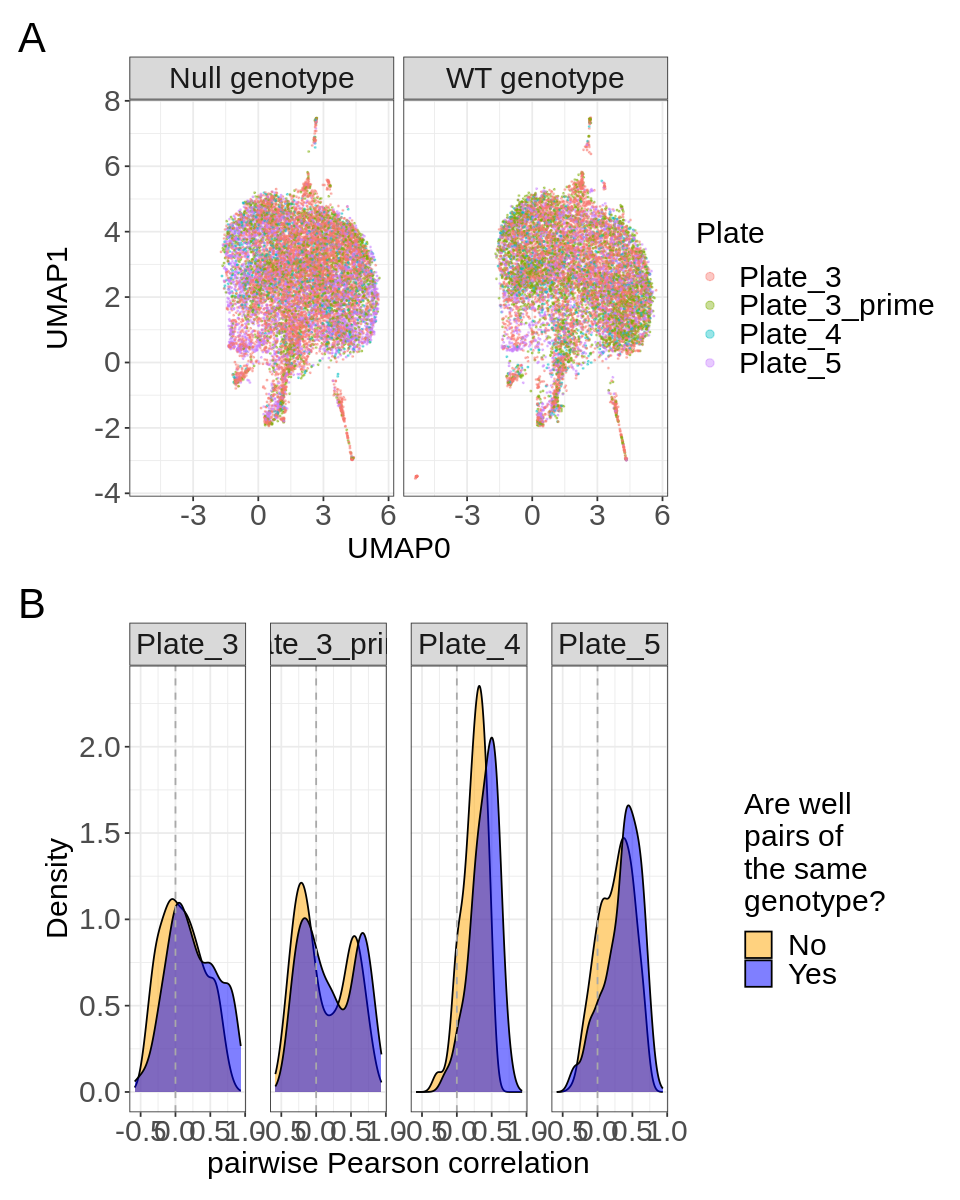

In [8]:
fig_2_gg <- (
  align_plot
) + plot_annotation(tag_levels = "A") & theme(plot.tag = element_text(size = 25))

# Save or display the plot
ggsave(output_main_figure_2, plot = fig_2_gg, dpi = 500, height = 12, width = 12)

fig_2_gg